# IMPORT

In [1]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sys import getsizeof

In [2]:
print(tf.__version__)

2.8.2


# FUNCTIONS

In [3]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [4]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

# IMPORT THE FASHION MNIST DATASET

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# EXPLORE THE DATA

In [7]:
train_images.shape

(60000, 28, 28)

In [8]:
len(train_labels)

60000

In [9]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

# TEST DATASET

In [10]:
test_images.shape

(10000, 28, 28)

In [11]:
len(test_labels)

10000

## PREPROCESSING

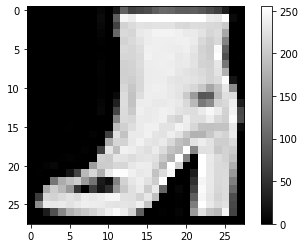

In [12]:
plt.figure()
plt.imshow(train_images[88], cmap="gray")
plt.colorbar()
plt.grid(False)
plt.show()

In [13]:
train_images = train_images / 255.0
test_images = test_images / 255.0

## BUILD AND COMPILE MODEL

In [14]:
model = keras.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10)
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4965 - accuracy: 0.8261
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3780 - accuracy: 0.8628
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3388 - accuracy: 0.8772
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3139 - accuracy: 0.8836
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2962 - accuracy: 0.8907
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2803 - accuracy: 0.8964
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2686 - accuracy: 0.9004
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2584 - accuracy: 0.9037
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2486 - accuracy: 0.9069
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.238

In [18]:
KERAS_MODEL_NAME = "tf_model_fashion_mnist.h5"

In [19]:
model.save(KERAS_MODEL_NAME)

In [20]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 1.191 Megabytes


In [21]:
keras_model_size = get_file_size(KERAS_MODEL_NAME)

In [22]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy is {}%'.format(round(100*test_acc, 2)))

313/313 - 1s - loss: 0.3273 - accuracy: 0.8850 - 567ms/epoch - 2ms/step

Test accuracy is 88.5%


# TENSORFLOW LITE MODEL

In [23]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

In [24]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpn2hb833r/assets


In [25]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

408628

In [26]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

File size: 399.051 Kilobytes


In [27]:
tflite_file_size = get_file_size(TF_LITE_MODEL_FILE_NAME)

# CHECK INPUT TENSOR SHAPE

In [28]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 28 28]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


# RESIZE TENSOR SHAPE

In [29]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    28    28]
Input Type: <class 'numpy.float32'>
Output Shape: [10000    10]
Output Type: <class 'numpy.float32'>


In [30]:
test_images.dtype

dtype('float64')

In [31]:
test_imgs_numpy = np.array(test_images, dtype=np.float32)

In [32]:
test_imgs_numpy.dtype

dtype('float32')

In [33]:
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (10000, 10)


In [34]:
acc = accuracy_score(prediction_classes, test_labels)

In [35]:
print('Test accuracy TFLITE model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE model is 88.5%


In [36]:
tflite_file_size/keras_model_size

0.32729200840680744

# TF LITE MODEL FLOAT 16

In [37]:
TF_LITE_MODEL_FLOAT_16_FILE_NAME = "tf_lite_float_16_model.tflite"

In [38]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpj21zc7si/assets


INFO:tensorflow:Assets written to: /tmp/tmpj21zc7si/assets


In [39]:
tflite_model_name = TF_LITE_MODEL_FLOAT_16_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

205696

In [40]:
convert_bytes(get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME), "KB")

File size: 200.875 Kilobytes


In [41]:
tflite_float_16_file_size = get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME)

In [42]:
tflite_float_16_file_size/keras_model_size

0.1647529218782038

In [43]:
tflite_float_16_file_size/tflite_file_size

0.5033820491987823

# TF LITE SIZE QUANTISED

In [44]:
TF_LITE_SIZE_QUANT_MODEL_FILE_NAME = "tf_lite_quant_model.tflite"

In [45]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpydm8_acp/assets


INFO:tensorflow:Assets written to: /tmp/tmpydm8_acp/assets


In [46]:
tflite_model_name = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

103936

In [47]:
convert_bytes(get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME), "KB")

File size: 101.5 Kilobytes


In [48]:
tflite_float_quant_file_size = get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)

In [49]:
tflite_float_quant_file_size/keras_model_size

0.0832478982981341

In [50]:
tflite_float_quant_file_size/ tflite_float_16_file_size

0.5052893590541382

# ACCURACY OF THE QUANTIZED MODEL

# CHECK INPUT TENSOR SHAPE

In [51]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 28 28]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


# RESIZE TENSOR SHAPE

In [52]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    28    28]
Input Type: <class 'numpy.float32'>
Output Shape: [10000    10]
Output Type: <class 'numpy.float32'>


In [53]:
test_images.dtype

dtype('float64')

In [54]:
test_imgs_numpy = np.array(test_images, dtype=np.float32)

In [55]:
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (10000, 10)


In [56]:
acc = accuracy_score(prediction_classes, test_labels)

In [57]:
print('Test accuracy TFLITE Quantized model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE Quantized model is 88.46%
